# TensorFlow 2.0

In [5]:
import os
from glob import glob

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets 

import matplotlib.pyplot as plt
%matplotlib inline

## Hyperparameter Tunning

In [6]:
num_epochs = 10
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

## Build Model

In [7]:
inputs = layers.Input(input_shape)
net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [8]:
# Model is the full model w/o custom layers
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
    loss='categorical_crossentropy',  # Loss Function 
    metrics=['accuracy']  # Metrics / Accuracy
)

# Data Preprocess

In [9]:
train_paths = glob('../dataset/cifar/train/*.png')
test_paths = glob('../dataset/cifar/test/*.png')

In [10]:
train_paths[:10]

['../dataset/cifar/train\\0_frog.png',
 '../dataset/cifar/train\\10000_automobile.png',
 '../dataset/cifar/train\\10001_frog.png',
 '../dataset/cifar/train\\10002_frog.png',
 '../dataset/cifar/train\\10003_ship.png',
 '../dataset/cifar/train\\10004_ship.png',
 '../dataset/cifar/train\\10005_cat.png',
 '../dataset/cifar/train\\10006_deer.png',
 '../dataset/cifar/train\\10007_frog.png',
 '../dataset/cifar/train\\10008_airplane.png']

In [11]:
test_paths[:10]

['../dataset/cifar/test\\0_cat.png',
 '../dataset/cifar/test\\1000_dog.png',
 '../dataset/cifar/test\\1001_airplane.png',
 '../dataset/cifar/test\\1002_ship.png',
 '../dataset/cifar/test\\1003_deer.png',
 '../dataset/cifar/test\\1004_ship.png',
 '../dataset/cifar/test\\1005_automobile.png',
 '../dataset/cifar/test\\1006_automobile.png',
 '../dataset/cifar/test\\1007_ship.png',
 '../dataset/cifar/test\\1008_truck.png']

In [12]:
path = train_paths[0]
path

'../dataset/cifar/train\\0_frog.png'

In [15]:
def get_class_name(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    return lbl_name

In [16]:
path, get_class_name(path)

('../dataset/cifar/train\\0_frog.png',
 <tf.Tensor: shape=(), dtype=string, numpy=b'frog'>)

In [17]:
class_names = [get_class_name(path) for path in train_paths]
class_names[:10]

[<tf.Tensor: shape=(), dtype=string, numpy=b'frog'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'automobile'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'frog'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'frog'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'ship'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'ship'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'cat'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'deer'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'frog'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'airplane'>]

In [20]:
classes = tf.unique(class_names).y.numpy()
classes

array([b'frog', b'automobile', b'ship', b'cat', b'deer', b'airplane',
       b'truck', b'dog', b'bird', b'horse'], dtype=object)

In [21]:
classes == get_class_name(path)

<tf.Tensor: shape=(10,), dtype=bool, numpy=
array([ True, False, False, False, False, False, False, False, False,
       False])>

In [22]:
onehot_encoding = tf.cast(classes == get_class_name(path), tf.uint8)

In [23]:
def onehot_encoding(label_name):
    classes == get_class_name(path)
    onehot_encoding = tf.cast(classes == get_class_name(path), tf.uint8)
    return onehot_encoding

In [41]:
def read_dataset(path):
    # read image
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    
    # normalization
    image = tf.cast(image, tf.float32) / 255.
    
    # read label
    class_name = get_class_name(path)
    label = onehot_encoding(class_name)
    return image, label

In [30]:
image, label = read_dataset(path)
image.shape, label.shape

(TensorShape([32, 32, 3]), TensorShape([10]))

In [31]:
def image_preprocess(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

In [34]:
transformed, label = image_preprocess(image, label)
transformed.shape

TensorShape([32, 32, 3])

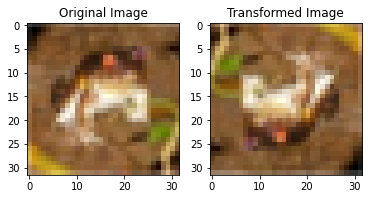

In [35]:
plt.subplot(121)
plt.title('Original Image')
plt.imshow(image)

plt.subplot(122)
plt.title('Transformed Image')
plt.imshow(transformed)
plt.show()

In [43]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(read_dataset)
train_dataset = train_dataset.map(image_preprocess) # transform images
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.repeat()

In [44]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(read_dataset)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=len(test_paths))
test_dataset = test_dataset.repeat()

### 종합 (커스텀)

In [ ]:
class_names = [get_class_name(path) for path in train_paths]  
classes = tf.unique(class_names).y.numpy()  

def get_class_name(path):  
    fname = tf.strings.split(path, '_')[-1]  
    lbl_name = tf.strings.regex_replace(fname, '.png', '')  
    return lbl_name  

def onehot_encoding(label_name):  
    classes == get_class_name(path)  
    onehot_encoding = tf.cast(classes == get_class_name(path), tf.uint8)  
    return onehot_encoding  

def read_dataset(path):    
    # read image  
    gfile = tf.io.read_file(path)  
    image = tf.io.decode_image(gfile)  
    
    # normalization  
    image = tf.cast(image, tf.float32) / 255.  
    
    # read label  
    class_name = get_class_name(path)  
    label = onehot_encoding(class_name)  
    return image, label  

def image_preprocess(image, label):  
    image = tf.image.random_flip_left_right(image)  
    image = tf.image.random_flip_up_down(image)  
    return image, label  

train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)  
train_dataset = train_dataset.map(read_dataset)  
train_dataset = train_dataset.map(image_preprocess) # transform images  
train_dataset = train_dataset.batch(batch_size)  
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))  
train_dataset = train_dataset.repeat()  

test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)  
test_dataset = test_dataset.map(read_dataset)  
test_dataset = test_dataset.batch(batch_size)  
test_dataset = test_dataset.shuffle(buffer_size=len(test_paths))  
test_dataset = test_dataset.repeat()  

## Training

In [47]:
# len(train_dataset)로 못구함
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

In [49]:
model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs
)

Epoch 1/10
1562/1562 [==============================] - 175s 91ms/step - loss: 4.9120e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
1562/1562 [==============================] - 139s 89ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
1562/1562 [==============================] - 141s 90ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
1562/1562 [==============================] - 142s 91ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
1562/1562 [==============================] - 142s 91ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
1562/1562 [==============================] - 141s 90ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
1562/1562 [==============================] - 142s 91ms/step